**Maestría en Inteligencia Artificial Aplicada**

**Curso: Proyecto Integrador**

**Tecnológico de Monterrey**

**Equipo 9**

**Jorge Luis Arroyo Chavelas (A01793023)**

# Avance 2. Ingeniería de características

## Introduction
In this analysis, we're building on what we learned from a first look at resumes. Our goal is to make our dataset better at identifying key parts of text—skills, education, and work experience—important for a matching system we're planning. These sections are basic to any resume, and being able to tell them apart in new texts is key to creating a solid scoring system.

We've identified these sections in our dataset, but the real work is in recognizing and categorizing them in new resumes. This step is crucial for our scoring system.

We're aiming to go beyond simple text analysis methods because they have their limits. We're focusing on the main parts of a resume, trying to organize unstructured text in a way that makes our matching system more accurate. This approach should help us link resume sections more closely to job requirements.

If we get this right, our method could be used not only for resumes but also for job descriptions. That's what we're working towards for now.

For this, first let's prepare the field:

In [16]:
## Choose False if you have access to the DB or True if you are using a csv replication file.
REPLICATION_FLAG = True

In [17]:
# Spacy library to do some NLP tasks.
!python -m spacy download en_core_web_sm -q

/Users/dataalchemist/Documents/GitHub/IRPO/IRPO_Public/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [18]:
## env variables
import os
from dotenv import load_dotenv

## Call and manage data
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
from collections import Counter

## NLP
import re
import nltk
import spacy

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

## Others
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Init
nltk.download('stopwords')
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")

load_dotenv()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dataalchemist/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dataalchemist/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Load

Now let's proceed calling the initial data

In [19]:
## Call data - either from DB or from csv file
if REPLICATION_FLAG:
    raw_data = pd.read_csv('extract.csv')
else: 
    DATABASE_URL = os.getenv("DATABASE_URL", "")
    engine = create_engine(DATABASE_URL)
    raw_data = pd.read_sql(text("SELECT * FROM public.ML_RESOURCE;"), engine.connect())
    raw_data.sample(n=100, random_state=42).to_csv('./extract.csv', index=False)

# Visualize data
print(f"dataframe of shape: {raw_data.shape}")
display(raw_data.head(2))

dataframe of shape: (100, 8)


,resource_id,resource_key,resource_title,resource_text,resource_summary,resource_skills,resource_experience,resource_education
0,856,2ffe961b6538466d843e05921b22c1e0,quality assurance analyst,Jessica Claire\n100 Montgomery St. 10th Floor\...,"Multilingual (Spanish, English, and Portuguese...",Hazardous Waste Disposal\nQuality Control\nRaw...,EXPERIENCE\n09/2021 to 08/2022\nQUALITY ASSURA...,EDUCATION AND TRAINING\n08/2021\nAssociate of ...
1,3420,f27332e197484d90b31890ddc10fabd0,front end assistant photo lab tech member serv...,JESSICA\nCLAIRE\nresumesample@example.com\n(55...,Motivated customer service specialist with ove...,Trusted key holder\nCreative problem solver\nE...,WORK HISTORY\nPeveto Brake Check - Front End A...,"EDUCATION\nCitrus College\nGlendora, CA\nAssoc..."


Now that we've accessed our dataset and identified the target columns containing the relevant text, our immediate objective is to structure this text for our training dataset in a way that aligns with our analysis goals. To achieve this, we plan to dissect the text within these columns line by line, treating each line as a separate observation. This approach will enable us to meticulously categorize each line under the appropriate feature type—be it skills, education, or work experience. Here's a glimpse of how our structured training dataset is expected to shape up:

|text_line|feature_type|
|---|---|
|Studied at Acme University|edication|
|SQL, R, Python|skills|
|...|...|

This structured format will facilitate a more granular and focused analysis, allowing us to apply our feature engineering and modeling techniques more effectively.

In [20]:
# Function to extract the lines
def extract_lines(df, col):
    """
    It takes a dataframe and a column and divides its content by the \n symbol.
    It throws back a dtype that can be used to generate a new dataframe
    """
    return (
        df[col]
        .str
        .split('\n', expand=True)
        .stack()
        .reset_index(level=1, drop=True)
        .rename('text_line')
    )

# Extract the lines for new dataframe
skills = extract_lines(raw_data, 'resource_skills')
education = extract_lines(raw_data, 'resource_education')
experience = extract_lines(raw_data, 'resource_experience')

# Creating a DataFrame from each Series and adding a feature column
df_skills = pd.DataFrame({'text_line': skills}).assign(feature='skills')
df_education = pd.DataFrame({'text_line': education}).assign(feature='education')
df_experience = pd.DataFrame({'text_line': experience}).assign(feature='experience')

# Concatenating all DataFrames into one
df = pd.concat([df_skills, df_education, df_experience], ignore_index=True)

# Displaying the DataFrame
df

,text_line,feature
0,Hazardous Waste Disposal,skills
1,Quality Control,skills
2,Raw Materials Receiving,skills
3,Laboratory Testing,skills
4,Good Work Ethic,skills
...,...,...
6248,Perform CAE analysis using MADYMO & LS-DYNA an...,experience
6249,Developed frontal airbags for Driver and passe...,experience
6250,Developed inflatable curtains for side impact ...,experience
6251,Developed Inflatable knee bolster to reduce in...,experience


With our dataset now structured and ready, we move on to the critical phase of feature generation and data cleaning. Given the way we've structured our data, removing nulls isn't necessary -—each line of text is already cleaned and linked to a specific feature type.

Words are the bedrock of our analysis, yet the nature of resume content -—with its bullet points, abbreviations, and various symbols -—poses unique challenges. Our first order of business is to clean the text. This involves stripping away non-essential symbols and punctuation while preserving alphanumeric characters, which hold significant value. Numbers, for example, are integral to our analysis, potentially offering insights into years of experience, academic achievements, and more.

This cleaning step is not just about removing unwanted characters; it's also about standardizing the text to a common baseline. Converting all text to lowercase ensures consistency, enabling us to treat words like 'Python' and 'python' as the same entity. 

In summary, our immediate focus is on refining our dataset through a cleaning process. This sets the stage for the advanced feature generation that follows, where we'll delve deeper into the text to uncover the nuances that distinguish skills, education, and experience in the complex tapestry of resumes.

## Data clean

In [21]:
# Cleaning function
def clean_text(text):
    """
    Cleans words of non alphanumeric parameters, it returns everything 
    in lowercase and without extra spaces.
    """

    # Keeping alphanumeric characters
    cleaned_text = re.sub(r'[^\w\s]', '', text)

    # Removing extra whitespaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    # making everything lowercase
    cleaned_text = cleaned_text.lower()

    return cleaned_text

# Applying the cleaning function to generate a new column with cleaned text
df['cleaned_text'] = df['text_line'].apply(clean_text)

# Displaying the DataFrame
df

,text_line,feature,cleaned_text
0,Hazardous Waste Disposal,skills,hazardous waste disposal
1,Quality Control,skills,quality control
2,Raw Materials Receiving,skills,raw materials receiving
3,Laboratory Testing,skills,laboratory testing
4,Good Work Ethic,skills,good work ethic
...,...,...,...
6248,Perform CAE analysis using MADYMO & LS-DYNA an...,experience,perform cae analysis using madymo lsdyna and c...
6249,Developed frontal airbags for Driver and passe...,experience,developed frontal airbags for driver and passe...
6250,Developed inflatable curtains for side impact ...,experience,developed inflatable curtains for side impact ...
6251,Developed Inflatable knee bolster to reduce in...,experience,developed inflatable knee bolster to reduce in...


## Feature Engineering
### Lexical Density

In our approach, we're taking a slightly different path from traditional NLP practices by choosing not to remove "stop words" from our text. Commonly, filtering out these words is a go-to method in many NLP tasks to reduce noise and focus on content-rich words. However, we're considering the broader context and potential overlap between sections like skills and experience, where stop words might actually contribute valuable context. Especially as we lean towards leveraging advanced NLP techniques such as transformers, the inclusion of these words can enrich the model's understanding of the text.

That said, we're still curious about the role and prevalence of stop words in our dataset. To satisfy this curiosity and gain deeper insights, we'll explore the lexical density across different sections of the resumes. Lexical density refers to the proportion of content-bearing words in a text, and by examining this metric, we can get a sense of how information-dense different parts of a resume are, even with stop words included. This exploration will not only shed light on the nature of text in each section but also inform our ongoing strategy for feature engineering and model development.

In [22]:
# Stopwords list
stop_words = set(nltk.corpus.stopwords.words('english'))

# Function to calculate lexical density
def lexical_density(text):
    """
    It measures the lexical density of a line of text
    """
    words = nltk.word_tokenize(text)
    lexical_words = [word for word in words if word.lower() not in stop_words and word.isalpha()]
    if len(words) == 0:
        return 0  # Avoid division by zero
    return len(lexical_words) / len(words)

# Applying the lexical density function to identify content-bearing in text
df['lexical_density'] = df['cleaned_text'].apply(lexical_density)

# Displaying the DataFrame
df

,text_line,feature,cleaned_text,lexical_density
0,Hazardous Waste Disposal,skills,hazardous waste disposal,1.000000
1,Quality Control,skills,quality control,1.000000
2,Raw Materials Receiving,skills,raw materials receiving,1.000000
3,Laboratory Testing,skills,laboratory testing,1.000000
4,Good Work Ethic,skills,good work ethic,1.000000
...,...,...,...,...
6248,Perform CAE analysis using MADYMO & LS-DYNA an...,experience,perform cae analysis using madymo lsdyna and c...,0.809524
6249,Developed frontal airbags for Driver and passe...,experience,developed frontal airbags for driver and passe...,0.636364
6250,Developed inflatable curtains for side impact ...,experience,developed inflatable curtains for side impact ...,0.800000
6251,Developed Inflatable knee bolster to reduce in...,experience,developed inflatable knee bolster to reduce in...,0.730769


Let's now look at how this lexical density looks by feature:

In [23]:
# Displaying the lexical density
df.groupby('feature')['lexical_density'].mean().reset_index()

,feature,lexical_density
0,education,0.604030
1,experience,0.733903
2,skills,0.915872


The distinctions in our data are becoming clearer, particularly in the usage of content-rich words within sections like skills. These sections tend to be more concise, relying less on common stop words and more on specific, information-dense terms. This trend seems to extend to the differences between experience and education sections as well, likely due to resumes often incorporating abbreviations, numerical data, and specialized terms (e.g., Latin phrases) in educational backgrounds.

Reflecting on this, it appears that the frequent use of stop words in work experience sections may be attributed to their narrative, sentence-based structure. This leads us to an intriguing hypothesis: sections characterized by narrative descriptions, such as work experiences, might exhibit a higher prevalence of verbs, given their role in sentence construction. To explore this further, we will apply a method to quantify verb usage across different resume sections. Our hypothesis suggests that we might observe notable variations in verb counts that align with the specific nature of each section (skills, education, work experience), adding another dimension to our feature set and enhancing our understanding of the textual characteristics inherent to each category.

### Verbs and nouns ratio

In [24]:
# Function to find nouns and verbs
def count_verbs_and_nouns(text):
    """
    Analyzes the input text using POS tagging to count verbs and nouns,
    and calculates the ratio of verbs to nouns.
    """
    doc = nlp(text)
    verb_count = sum(token.pos_ == "VERB" for token in doc)
    noun_count = sum(token.pos_ == "NOUN" for token in doc)
    
    # Calculate verb-to-noun ratio, handling the case where noun_count is 0 to avoid division by zero
    verb_noun_ratio = verb_count / noun_count if noun_count else 0

    return verb_count, noun_count, verb_noun_ratio

# Applying the function to the cleaned_text column and expand the results into three new columns
df[['verb_count', 'noun_count', 'verb_noun_ratio']] = df['cleaned_text'].apply(lambda x: pd.Series(count_verbs_and_nouns(x)))

# Display the updated DataFrame to verify the new columns
display(df)

,text_line,feature,cleaned_text,lexical_density,verb_count,noun_count,verb_noun_ratio
0,Hazardous Waste Disposal,skills,hazardous waste disposal,1.000000,0.0,2.0,0.000000
1,Quality Control,skills,quality control,1.000000,0.0,2.0,0.000000
2,Raw Materials Receiving,skills,raw materials receiving,1.000000,1.0,1.0,1.000000
3,Laboratory Testing,skills,laboratory testing,1.000000,0.0,2.0,0.000000
4,Good Work Ethic,skills,good work ethic,1.000000,0.0,1.0,0.000000
...,...,...,...,...,...,...,...
6248,Perform CAE analysis using MADYMO & LS-DYNA an...,experience,perform cae analysis using madymo lsdyna and c...,0.809524,5.0,10.0,0.500000
6249,Developed frontal airbags for Driver and passe...,experience,developed frontal airbags for driver and passe...,0.636364,1.0,5.0,0.200000
6250,Developed inflatable curtains for side impact ...,experience,developed inflatable curtains for side impact ...,0.800000,1.0,6.0,0.166667
6251,Developed Inflatable knee bolster to reduce in...,experience,developed inflatable knee bolster to reduce in...,0.730769,4.0,11.0,0.363636


In [25]:
# Displaying the verb vs noun ratio:
df.groupby('feature')['verb_noun_ratio'].mean().reset_index()

,feature,verb_noun_ratio
0,education,0.046761
1,experience,0.351866
2,skills,0.184671


The analysis reveals a compelling pattern: work experience sections tend to have a higher verb-to-noun ratio compared to education and skills sections. This metric, chosen for its normalization and independence from line length, supports our hypothesis that work experience narratives are more sentence-driven. This contrasts with the skills section, which, often formatted as bullet points, shows a reduced presence of stop words and a more concise structure.

Turning our attention to education, this section typically features entities such as academic institutions and dates. While dates are also common in work experience, particularly in the context of employment periods, the inclusion of financial figures related to projects could offer a distinguishing factor. This leads us to an intriguing avenue of exploration: the potential to differentiate sections by extracting specific entities from the text.

By employing entity recognition, we aim to identify and count occurrences of geographical locations (GPE), dates (DATE), organizations (ORG), and monetary values (MONEY). We plan to normalize these counts by the total word count in each line, offering a nuanced perspective on the text's nature. This approach could provide valuable insights into distinguishing between sections, leveraging the unique characteristics of each to enhance our feature set. Through this method, we hope to further refine our understanding of the dataset and improve the model's ability to classify text segments accurately.

### Entity recognition

In [26]:
# Function for entity recognition
def identify_and_normalize_entities(text):
    """
    Identifies specific entities (ORG, DATE, GPE, MONEY) in the text using spaCy's NER and normalizes
    the counts by the total word count to provide a relative measure of entity presence.
    """
    doc = nlp(text)
    word_count = len(doc)

    # Initialize counts for desired entities
    entity_counts = {'ORG': 0, 'DATE': 0, 'GPE': 0, 'MONEY': 0}

    # Count occurrences of specified entities
    for ent in doc.ents:
        if ent.label_ in entity_counts:
            entity_counts[ent.label_] += 1

    # Normalize entity counts by the total word count
    normalized_entity_counts = {entity: (count / word_count if word_count else 0) for entity, count in entity_counts.items()}

    return normalized_entity_counts

# Applyng the enhanced entity recognition function to the cleaned text
entity_columns = df['cleaned_text'].apply(identify_and_normalize_entities).apply(pd.Series)

# Merge the new entity columns with the original DataFrame
df = pd.concat([df, entity_columns], axis=1)

# Display the updated DataFrame
df

,text_line,feature,cleaned_text,lexical_density,verb_count,noun_count,verb_noun_ratio,ORG,DATE,GPE,MONEY
0,Hazardous Waste Disposal,skills,hazardous waste disposal,1.000000,0.0,2.0,0.000000,0.0,0.0,0.0,0.0
1,Quality Control,skills,quality control,1.000000,0.0,2.0,0.000000,0.0,0.0,0.0,0.0
2,Raw Materials Receiving,skills,raw materials receiving,1.000000,1.0,1.0,1.000000,0.0,0.0,0.0,0.0
3,Laboratory Testing,skills,laboratory testing,1.000000,0.0,2.0,0.000000,0.0,0.0,0.0,0.0
4,Good Work Ethic,skills,good work ethic,1.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6248,Perform CAE analysis using MADYMO & LS-DYNA an...,experience,perform cae analysis using madymo lsdyna and c...,0.809524,5.0,10.0,0.500000,0.0,0.0,0.0,0.0
6249,Developed frontal airbags for Driver and passe...,experience,developed frontal airbags for driver and passe...,0.636364,1.0,5.0,0.200000,0.0,0.0,0.0,0.0
6250,Developed inflatable curtains for side impact ...,experience,developed inflatable curtains for side impact ...,0.800000,1.0,6.0,0.166667,0.0,0.0,0.0,0.0
6251,Developed Inflatable knee bolster to reduce in...,experience,developed inflatable knee bolster to reduce in...,0.730769,4.0,11.0,0.363636,0.0,0.0,0.0,0.0


In [27]:
# Table visualization of features vs entity recognition.
display(df.groupby('feature')[['ORG', 'DATE', 'GPE', 'MONEY']].mean())

,ORG,DATE,GPE,MONEY
feature,,,,
education,0.044123,0.074751,0.019414,0.000000
experience,0.012844,0.023046,0.004384,0.000122
skills,0.021531,0.005042,0.001072,0.000000


The initial observation from our analysis highlights a unique characteristic: the entity 'Money' exclusively appears within the work experience sections of our dataset, underscoring its relevance to narratives about professional achievements and roles. Additionally, we observe that 'Dates' are predominantly found in the education section, aligning with the expectation that academic timelines play a crucial role in this segment. Similarly, 'GPE' (Geopolitical Entities) tend to be more frequent in education, likely reflecting the locations of educational institutions.

These findings resonate with our intuitive understanding of resume content: education sections often detail academic affiliations and timelines, skills sections succinctly list competencies and expertise, and experience sections weave a narrative around professional journeys, including financial aspects of projects or roles. The consistency of these patterns suggests that these features could indeed be meaningful for distinguishing between different resume sections.

To further validate the potential of these features for classification, we propose conducting a Principal Component Analysis (PCA) for dimensionality reduction. By applying PCA to the features we've engineered, we aim to visualize any inherent clustering within the data, potentially revealing distinct groupings that correspond to the different resume sections. This step will provide valuable insights into the effectiveness of our feature set and inform our approach to developing a more refined classification model.

### Sections are easily disnguishable hypotesis

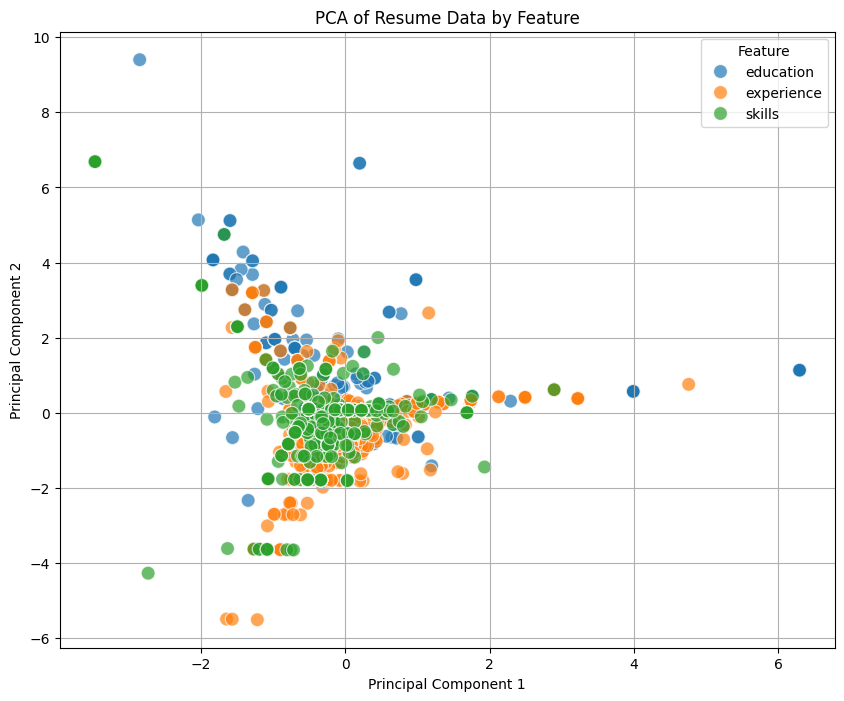

In [28]:
# Balance the dataset by sampling an equal number of rows for each feature category
min_count = df['feature'].value_counts().min()
balanced_df = pd.concat([sub_df.sample(n=min_count, random_state=42) for feature, sub_df in df.groupby('feature')])

# Selecting the relevant features for PCA
features_for_pca = ['lexical_density', 'verb_noun_ratio', 'ORG', 'GPE', 'DATE', 'MONEY']

# Extracting the feature values from the balanced dataset
X_balanced = balanced_df[features_for_pca]

# Standardizing the features to have a mean of 0 and a variance of 1
X_standardized = StandardScaler().fit_transform(X_balanced)

# Performing PCA to reduce the data to 2 principal components for visualization purposes
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_standardized)

# Creating a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Adding the 'feature' column to the DataFrame for color coding in the plot
final_df = pd.concat([principal_df, balanced_df[['feature']].reset_index(drop=True)], axis=1)

# Visualizing the 2D projection with a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='feature', data=final_df, alpha=0.7, s=100)
plt.title('PCA of Resume Data by Feature')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Feature', loc='best')
plt.grid(True)
plt.show()

The insights from our PCA analysis reveal an interesting aspect of our dataset: the clear delineation we anticipated between the resume sections—skills, education, and work experience—is not as distinct as we had hypothesized. The visualization indicates some overlap among the categories, suggesting that while the features we've developed are insightful, achieving precise classification using traditional methods may present challenges.

This observation aligns with the inherent complexity of resumes, where the significance of words extends beyond their mere presence to include context and semantic depth. Traditional feature engineering and PCA might not fully capture these subtleties, highlighting the potential need for more advanced, context-aware approaches.

Although exploring such sophisticated models goes beyond the scope of this notebook, our feature engineering efforts have laid a solid foundation. We've applied various techniques, including text cleaning, lexical analysis, and entity recognition, each bringing us closer to understanding the nuanced nature of our data.

As we wrap up this phase, we take a moment to review our dataset, now enriched with valuable features and cleaned for clarity:

In [29]:
# Engineered dataset:
df = df[['text_line', 'cleaned_text', 'lexical_density'
    , 'verb_noun_ratio', 'ORG', 'GPE', 'DATE', 'MONEY'
    , 'feature']]

df

,text_line,cleaned_text,lexical_density,verb_noun_ratio,ORG,GPE,DATE,MONEY,feature
0,Hazardous Waste Disposal,hazardous waste disposal,1.000000,0.000000,0.0,0.0,0.0,0.0,skills
1,Quality Control,quality control,1.000000,0.000000,0.0,0.0,0.0,0.0,skills
2,Raw Materials Receiving,raw materials receiving,1.000000,1.000000,0.0,0.0,0.0,0.0,skills
3,Laboratory Testing,laboratory testing,1.000000,0.000000,0.0,0.0,0.0,0.0,skills
4,Good Work Ethic,good work ethic,1.000000,0.000000,0.0,0.0,0.0,0.0,skills
...,...,...,...,...,...,...,...,...,...
6248,Perform CAE analysis using MADYMO & LS-DYNA an...,perform cae analysis using madymo lsdyna and c...,0.809524,0.500000,0.0,0.0,0.0,0.0,experience
6249,Developed frontal airbags for Driver and passe...,developed frontal airbags for driver and passe...,0.636364,0.200000,0.0,0.0,0.0,0.0,experience
6250,Developed inflatable curtains for side impact ...,developed inflatable curtains for side impact ...,0.800000,0.166667,0.0,0.0,0.0,0.0,experience
6251,Developed Inflatable knee bolster to reduce in...,developed inflatable knee bolster to reduce in...,0.730769,0.363636,0.0,0.0,0.0,0.0,experience


This dataset, a product of our feature engineering, is prepared for further analysis or modeling, embodying the progress we've made in unraveling the complexities of resume data.

## Conclussion

In this notebook, we took a shot at understanding resumes better by playing around with feature engineering. Our main goal was to sort out the text into skills, education, and work experience, making it easier to handle for any future tasks. We started by cleaning up the text, keeping it straightforward by removing unnecessary characters and making everything lowercase.

We then moved on to check out how dense the text was with useful information and tried to spot specific entities like organizations, dates, and places. Our dive into PCA gave us a peek at how these sections might overlap more than we initially thought, hinting that just slicing and dicing the data might not cut it for perfect classification.

Even though we hit some snags and the process wasn't as smooth as we'd hoped, we still managed to clean up our data and add some interesting features along the way. This exercise opened our eyes to the challenges of working with resume data and the need for maybe a smarter approach, like using models that get the context and the subtleties of language a bit better (transformers).

Wrapping up, we've got a dataset that's in better shape than when we started, with some neat features tagged on. This notebook was more about setting the stage and getting our hands dirty with the data, and it's pretty clear there's more work to be done to really nail down those classifications.